In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from scipy import stats

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
df = pd.read_csv("/content/drive/MyDrive/AI ML/california_housing.csv")

In [20]:
print(df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


Feature Engineering Assignment
Dataset: California Housing Dataset

In [21]:
# 1. HANDLE MISSING VALUES
print("\n--- 1. Handle Missing Values ---")

np.random.seed(42)
missing_idx = np.random.choice(df.index, size=200, replace=False)
df.loc[missing_idx[:100], 'AveRooms'] = np.nan
df.loc[missing_idx[100:], 'HouseAge'] = np.nan

print("Missing values before handling:\n", df.isnull().sum())

df['AveRooms'] = df['AveRooms'].fillna(df['AveRooms'].median())
df['HouseAge'] = df['HouseAge'].fillna(df['HouseAge'].median())

print("Missing values after handling:\n", df.isnull().sum())


--- 1. Handle Missing Values ---
Missing values before handling:
 MedInc          0
HouseAge      100
AveRooms      100
AveBedrms       0
Population      0
AveOccup        0
Latitude        0
Longitude       0
dtype: int64
Missing values after handling:
 MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


In [22]:
# 2. HANDLE CATEGORICAL VALUES

print("\n--- 2. Handle Categorical Values ---")

df['Region'] = pd.cut(
    df['Longitude'],
    bins=[-125, -121, -118, -114],
    labels=['Northern_Coast', 'Central_Coast', 'Southern']
)
print("Region value counts:\n", df['Region'].value_counts())

df = pd.get_dummies(df, columns=['Region'], drop_first=False)
print("Columns after One-Hot Encoding:", df.columns.tolist())


--- 2. Handle Categorical Values ---
Region value counts:
 Region
Central_Coast     8387
Northern_Coast    7173
Southern          5080
Name: count, dtype: int64
Columns after One-Hot Encoding: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'Region_Northern_Coast', 'Region_Central_Coast', 'Region_Southern']


In [23]:
# 3. SCALE THE FEATURES

print("\n--- 3. Scale the Features ---")

numerical_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                  'Population', 'AveOccup', 'Latitude', 'Longitude']

print("Before Scaling - MedInc stats:\n", df['MedInc'].describe().round(3))

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("\nAfter Scaling - MedInc stats:\n", df_scaled['MedInc'].describe().round(3))


--- 3. Scale the Features ---
Before Scaling - MedInc stats:
 count    20640.000
mean         3.871
std          1.900
min          0.500
25%          2.563
50%          3.535
75%          4.743
max         15.000
Name: MedInc, dtype: float64

After Scaling - MedInc stats:
 count    20640.000
mean         0.000
std          1.000
min         -1.774
25%         -0.688
50%         -0.177
75%          0.459
max          5.858
Name: MedInc, dtype: float64



--- 4. Remove Outliers ---
Shape before outlier removal: (20640, 11)
Shape after outlier removal: (19794, 11)
Rows removed: 846


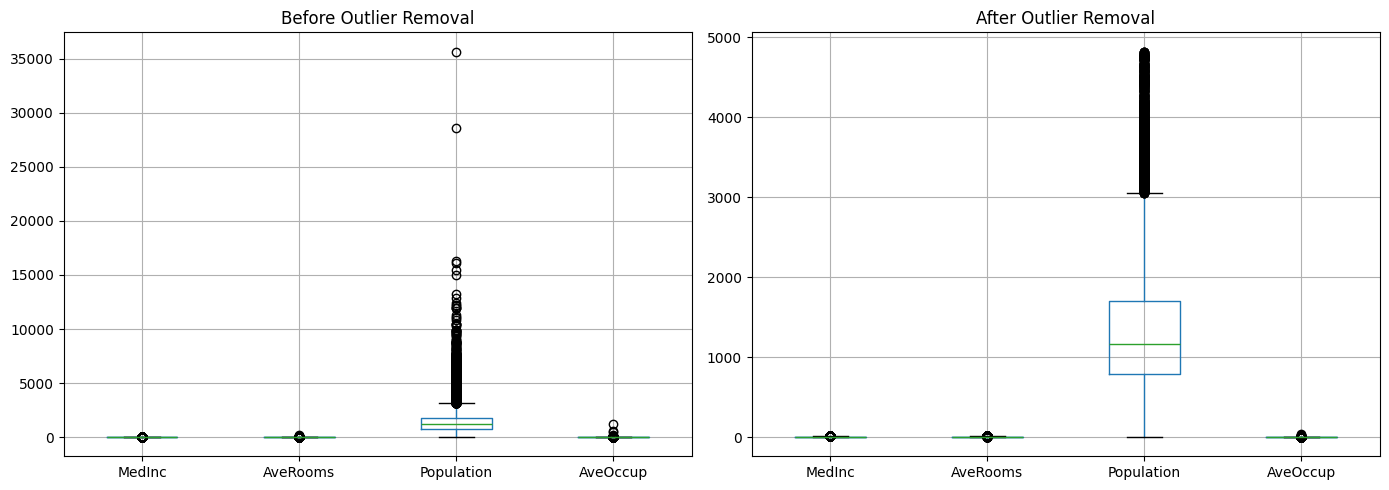

In [24]:
# 4. REMOVE OUTLIERS

print("\n--- 4. Remove Outliers ---")
print("Shape before outlier removal:", df.shape)

z_scores = np.abs(stats.zscore(df[numerical_cols], nan_policy='omit'))
mask = (z_scores < 3).all(axis=1)

df_clean = df[mask].copy()
df_scaled_clean = df_scaled[mask].copy()

print("Shape after outlier removal:", df_clean.shape)
print(f"Rows removed: {(~mask).sum()}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df[['MedInc', 'AveRooms', 'Population', 'AveOccup']].boxplot(ax=axes[0])
axes[0].set_title("Before Outlier Removal")
df_clean[['MedInc', 'AveRooms', 'Population', 'AveOccup']].boxplot(ax=axes[1])
axes[1].set_title("After Outlier Removal")
plt.tight_layout()
plt.savefig("outlier_comparison.png", dpi=100)
plt.show()
plt.close()


--- 5. Feature Selection ---

Feature Importances:
 AveRooms      0.5167
AveBedrms     0.1628
Latitude      0.1058
Longitude     0.0838
AveOccup      0.0554
Population    0.0385
HouseAge      0.0370
dtype: float64


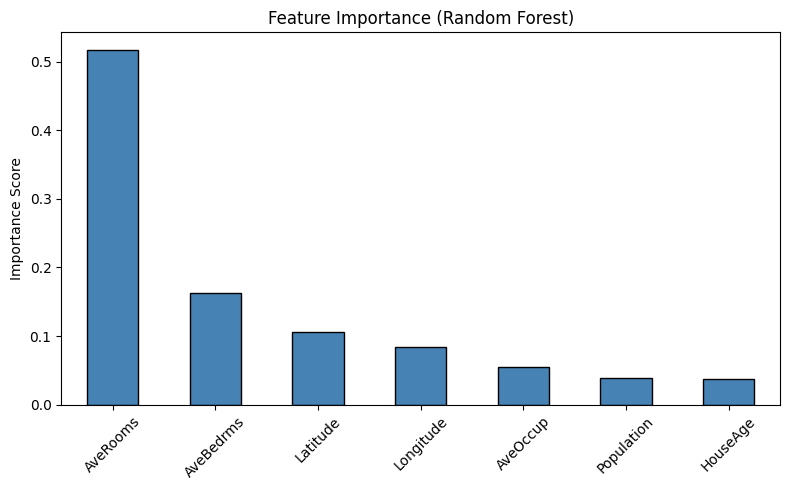

Selected Top Features (importance > 5%): ['AveRooms', 'AveBedrms', 'Latitude', 'Longitude', 'AveOccup']


In [25]:
# 5. FEATURE SELECTION

print("\n--- 5. Feature Selection ---")

ohe_cols = [c for c in df_scaled_clean.columns if c.startswith('Region_')]
df_scaled_clean[ohe_cols] = df_scaled_clean[ohe_cols].astype(int)

corr_matrix = df_scaled_clean[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=100)
plt.close()

feature_cols = [c for c in numerical_cols if c != 'MedInc']
X_feat = df_scaled_clean[feature_cols]
y_feat = df_scaled_clean['MedInc']

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_feat, y_feat)

importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nFeature Importances:\n", importances.round(4))

plt.figure(figsize=(8, 5))
importances.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=100)
plt.show()
plt.close()

top_features = importances[importances > 0.05].index.tolist()
print("Selected Top Features (importance > 5%):", top_features)


--- 6. PCA ---
Explained Variance per Component: [0.4299 0.2462 0.1708 0.0959 0.0357]
Cumulative Explained Variance:    [0.4299 0.6761 0.8469 0.9428 0.9786]


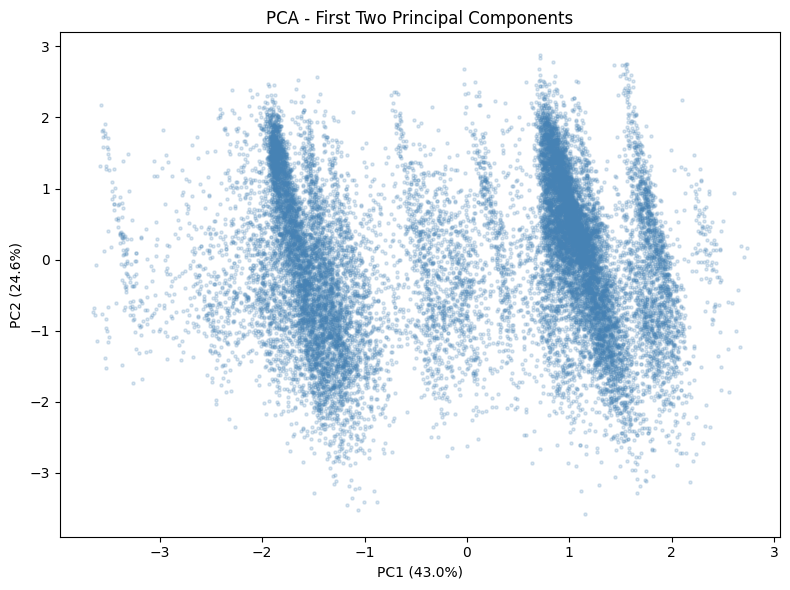

In [26]:
# 6. PCA

print("\n--- 6. PCA ---")

X_pca_input = df_scaled_clean[numerical_cols]
pca = PCA(n_components=5)
pca_result = pca.fit_transform(X_pca_input)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Explained Variance per Component:", np.round(explained_variance, 4))
print("Cumulative Explained Variance:   ", np.round(cumulative_variance, 4))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), explained_variance * 100, 'bo-', label='Individual')
plt.plot(range(1, 6), cumulative_variance * 100, 'rs--', label='Cumulative')
plt.axhline(y=90, color='gray', linestyle=':', label='90% Threshold')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.title("PCA Scree Plot")
plt.legend()
plt.tight_layout()
plt.savefig("pca_scree_plot.png", dpi=100)
plt.close()

pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(5)])
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, s=5, color='steelblue')
plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)")
plt.title("PCA - First Two Principal Components")
plt.tight_layout()
plt.savefig("pca_scatter.png", dpi=100)
plt.show()
plt.close()